# How to create Figure 5


**Paper:** https://arxiv.org/pdf/2002.09301.pdf



In [ ]:

import numpy as np
import matplotlib.pyplot as plt

from odefilters import odesolver, ode
from odefilters import linearised_odesolver as linsolver
from odefilters import linearised_ode as linode
from odefilters import statespace
from odefilters import inverseproblem as ip
from odefilters.optimisation import minimise_newton, minimise_gd, minimise_rs
from sampling_functions import *

## Optimisation experiments

In [3]:
thetatrue_classic = np.array([0.07, 0.6, 0.05, 0.3, 0.017, 0.3])

def create_data(solver, ivp, thetatrue, stepsize, ivpvar):
    """
    Create artificial data for the inverse problem.
    """
    ivp.params = thetatrue
    tsteps, m, __ = solver.solve(ivp, stepsize)
    means = odesolver.get_trajectory_ddim(m, 5, 0)
    evalpts = np.array([1., 2., 4., 5., 7., 10., 15., 20., 30., 40., 50., 60., 80., 100.])
    assert(np.prod(np.in1d(evalpts, tsteps))==1), print(evalpts[np.in1d(evalpts, tsteps)==False])
    noise = np.sqrt(ivpvar)*np.random.randn(len(evalpts)*5).reshape((len(evalpts), 5))
    evalidcs = [list(tsteps).index(evalpt) for evalpt in evalpts]
    data = means[evalidcs] + noise # this is 'wrong' noise
    ipdata = ip.InvProblemData(evalpts, data, ivpvar)
    return ipdata


def classic_rhs(t, x, params=thetatrue_classic):
    """
    RHS version without any linearisation.
    """
    x_1, x_2, x_3, x_4, x_5 = x
    k_1, k_2, k_3, k_4, v, km = params
    x_1_new = -k_1*x_1 - k_2*x_1*x_3 + k_3*x_4
    x_2_new = k_1 * x_1
    x_3_new = -k_2*x_1*x_3 + k_3*x_4 + v*x_5/(km + x_5)
    x_4_new = k_2*x_1*x_3 - k_3*x_4 - k_4*x_4
    x_5_new = k_4*x_4 - v*x_5/(km + x_5)
    return np.array([x_1_new, x_2_new, x_3_new, x_4_new, x_5_new])

In [4]:
thetatrue_classic = np.array([0.07, 0.6, 0.05, 0.3, 0.017, 0.3])

np.random.seed(2)

# Set Model Parameters
initial_value = [1., 0., 1., 0., 0.]

initial_time, end_time = 0., 100.
ivpvar = 1e-8
thetatrue = thetatrue_classic[:-1]  # all but the last one
ivp = linode.SignalTransduction(initial_time, end_time, params=thetatrue, initval=initial_value)
classic_ode = ode.CustomODE(initial_time, end_time, modeval=classic_rhs, initval=initial_value)

# Set Method Parameters
h_for_data = (end_time - initial_time)/10000
h = (end_time - initial_time)/2000
datasolver = odesolver.ODESolver(statespace.IBM(q=1, dim=5))
solver = linsolver.LinearisedODESolver(statespace.IBM(q=1, dim=5))
ipdata = create_data(datasolver, classic_ode, thetatrue, h_for_data, ivpvar)
iplklhd = ip.InvProblemLklhd(ipdata, ivp, solver, h, with_jacob=True)


In [5]:
niter = 200
init_theta = 3*np.array([0.08, 0.6, 0.05, 0.3, 0.017])


traj_gd, obj_gd = minimise_gd(iplklhd.potenteval, iplklhd.gradeval, niter, init_theta, lrate=1e-5)
error_gd = np.sqrt(np.sum(np.abs(traj_gd - thetatrue)**2/(1) ,axis=-1))

traj_newton, obj_newton = minimise_newton(iplklhd.potenteval, iplklhd.gradeval, iplklhd.hesseval, niter, init_theta, lrate=0.25)
error_newton = np.sqrt(np.sum(np.abs(traj_newton - thetatrue)**2/(1) ,axis=-1))

traj_rs, obj_rs = minimise_rs(iplklhd.potenteval, niter, init_theta, lrate=1e-2)
error_rs = np.sqrt(np.sum(np.abs(traj_rs - thetatrue)**2/(1 ) ,axis=-1))

In [6]:
print("Newton guess:", traj_newton[-1])
print("GD guess:", traj_gd[-1])
print("RS guess:", traj_rs[-1])
print("Truth:", thetatrue)
print("Init:", init_theta)

Newton guess: [0.07020031 0.59634861 0.0465323  0.29939664 0.02292834]
GD guess: [0.06379626 0.84939226 0.16420222 0.33450281 0.07984923]
RS guess: [0.14769201 1.68335146 0.26686808 0.71676787 0.0274732 ]
Truth: [0.07  0.6   0.05  0.3   0.017]
Init: [0.24  1.8   0.15  0.9   0.051]


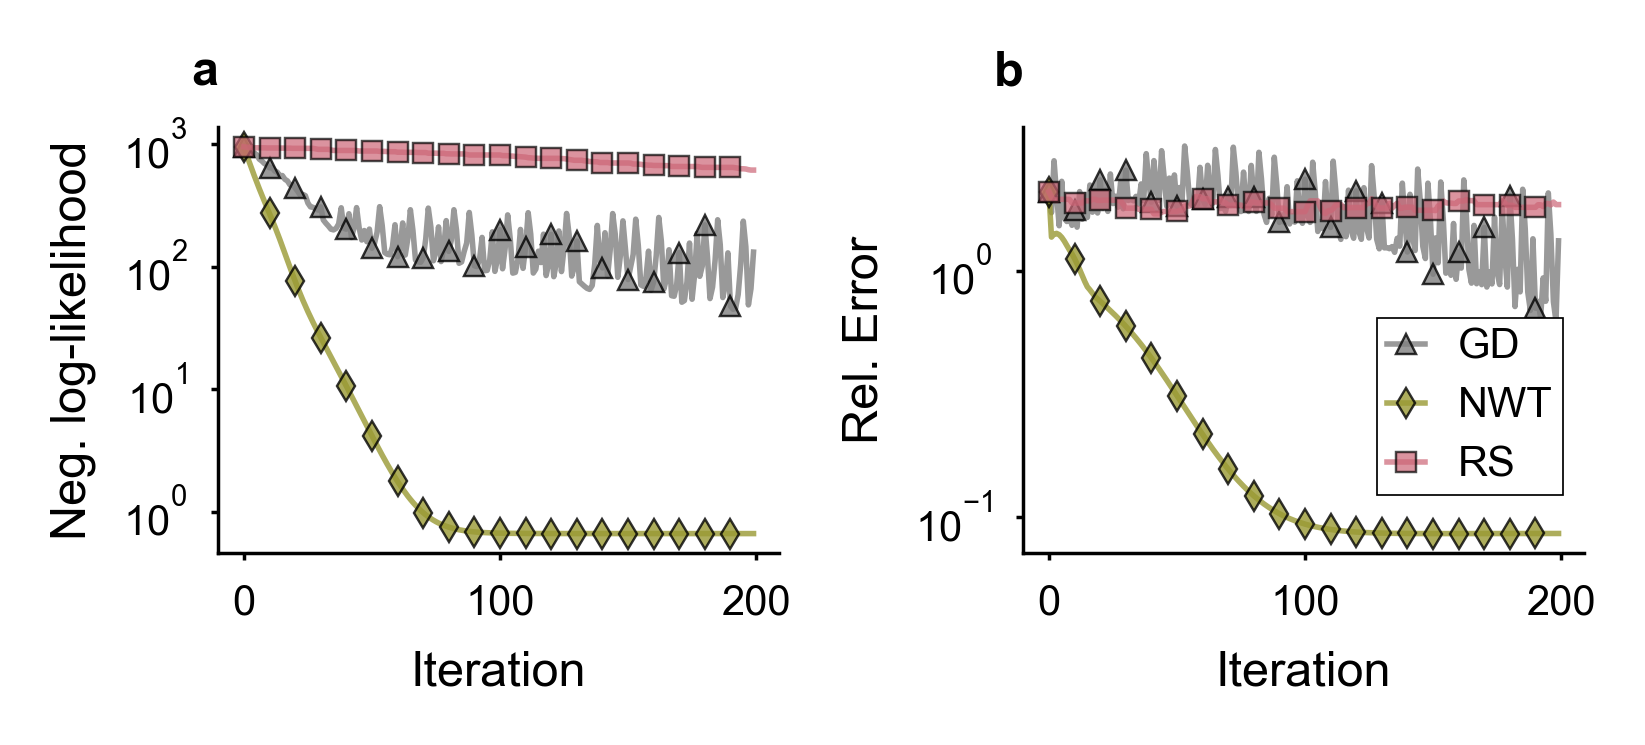

In [7]:
plt.style.use("./icmlstyle.mplstyle")

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)


prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

ax1.set_xlabel("Iteration")
ax1.set_ylabel("Neg. log-likelihood")
mark_every = 10
ax1.semilogy((obj_gd), markevery=mark_every, color="gray", ls="-", marker="^", label="GD", alpha=0.8)
ax1.semilogy((obj_newton), markevery=mark_every, color="#999933", ls="-", marker="d", label="NWT", alpha=0.8)
ax1.semilogy((obj_rs), markevery=mark_every, color="#cc6677",   ls="-", marker="s", label="RS", alpha=0.7)

ax2.set_xlabel("Iteration")
ax2.set_ylabel("Rel. Error")
ax2.semilogy(np.abs((traj_gd - thetatrue[np.newaxis, :])/thetatrue[np.newaxis, :]).mean(axis=1),  markevery=mark_every, color="gray", ls="-", marker="^", label="GD", alpha=0.8)
ax2.semilogy(np.abs((traj_newton - thetatrue[np.newaxis, :])/thetatrue[np.newaxis, :]).mean(axis=1), markevery=mark_every, color="#999933", ls="-", marker="d", label="NWT", alpha=0.8)
ax2.semilogy(np.abs((traj_rs - thetatrue[np.newaxis, :])/thetatrue[np.newaxis, :]).mean(axis=1), markevery=mark_every, color="#cc6677",  ls="-", marker="s", label="RS", alpha=0.7)

ax2.legend(loc='upper right', bbox_to_anchor=(1.0, 0.6))
ax1.minorticks_off()
ax2.minorticks_off()
ax1.set_title("a", loc="left", fontweight='bold', ha='right')
ax2.set_title("b", loc="left", fontweight='bold', ha='right')

plt.tight_layout()
plt.savefig("./figures/figure5_optim_left")

plt.show()

## Sampling experiments

In [9]:
def create_data(solver, ivp, thetatrue, stepsize, ivpvar):
    """
    Create artificial data for the inverse problem.
    """
    ivp.params = thetatrue
    tsteps, m, __, __, __ = solver.solve(ivp, stepsize)
    means = odesolver.get_trajectory_ddim(m, 5, 0)
    evalpts = np.array([1., 2., 4., 5., 7., 10., 15., 20., 30., 40., 50., 60., 80., 100.])
    assert(np.prod(np.in1d(evalpts, tsteps))==1), print(evalpts[np.in1d(evalpts, tsteps)==False])
    noise = np.sqrt(ivpvar)*np.random.randn(len(evalpts)*5).reshape((len(evalpts), 5))
    evalidcs = [list(tsteps).index(evalpt) for evalpt in evalpts]
    data = means[evalidcs] + noise # this is 'wrong' noise
    ipdata = ip.InvProblemData(evalpts, data, ivpvar)
    return ipdata

In [10]:
# Set Model Parameters
initial_value = [1., 0., 1., 0., 0.]

initial_time, end_time = 0., 100.
ivpvar = 1e-8
thetatrue = thetatrue_classic[:-1]  # all but the last one
ivp = linode.SignalTransduction(initial_time, end_time, params=thetatrue, initval=initial_value)

# Set Method Parameters
h_for_data = (end_time - initial_time)/10000
h = (end_time - initial_time)/2000
solver = linsolver.LinearisedODESolver(statespace.IBM(q=1, dim=5))
ipdata = create_data(solver, ivp, thetatrue, h_for_data, ivpvar)
iplklhd = ip.InvProblemLklhd(ipdata, ivp, solver, h, with_jacob=True)

In [11]:
# Make a particle follow a trajectory through the parameter space
niter = 500
init_theta = 3*np.array([0.08, 0.6, 0.05, 0.3, 0.017])
samples_ham, probs_ham = hamiltonian(niter, iplklhd, init_theta,stepsize=0.9, nsteps=1, ninits=100)
samples_lang, probs_lang = langevin(niter, iplklhd, init_theta, stepsize=0.2, ninits=100)
samples_rw, probs_rw = randomwalk(niter, iplklhd, init_theta, stepsize=.0001, ninits=100)

HAMILTONIAN
ratio 0.77
Langevin
ratio 0.722
RW
ratio 0.334


In [12]:
# print("pHam mode:", samples_ham[np.argmin(probs_ham)])
print("pLang mode:", samples_lang[np.argmin(probs_lang)])
print("RW mode:", samples_rw[np.argmin(probs_rw)])
print("Truth:", thetatrue)
print("Init:", init_theta)

pLang mode: [0.07030372 0.5825167  0.04418198 0.29759028 0.0170408 ]
RW mode: [0.07004098 1.64558905 0.60163094 0.33064704 0.01558608]
Truth: [0.07  0.6   0.05  0.3   0.017]
Init: [0.24  1.8   0.15  0.9   0.051]


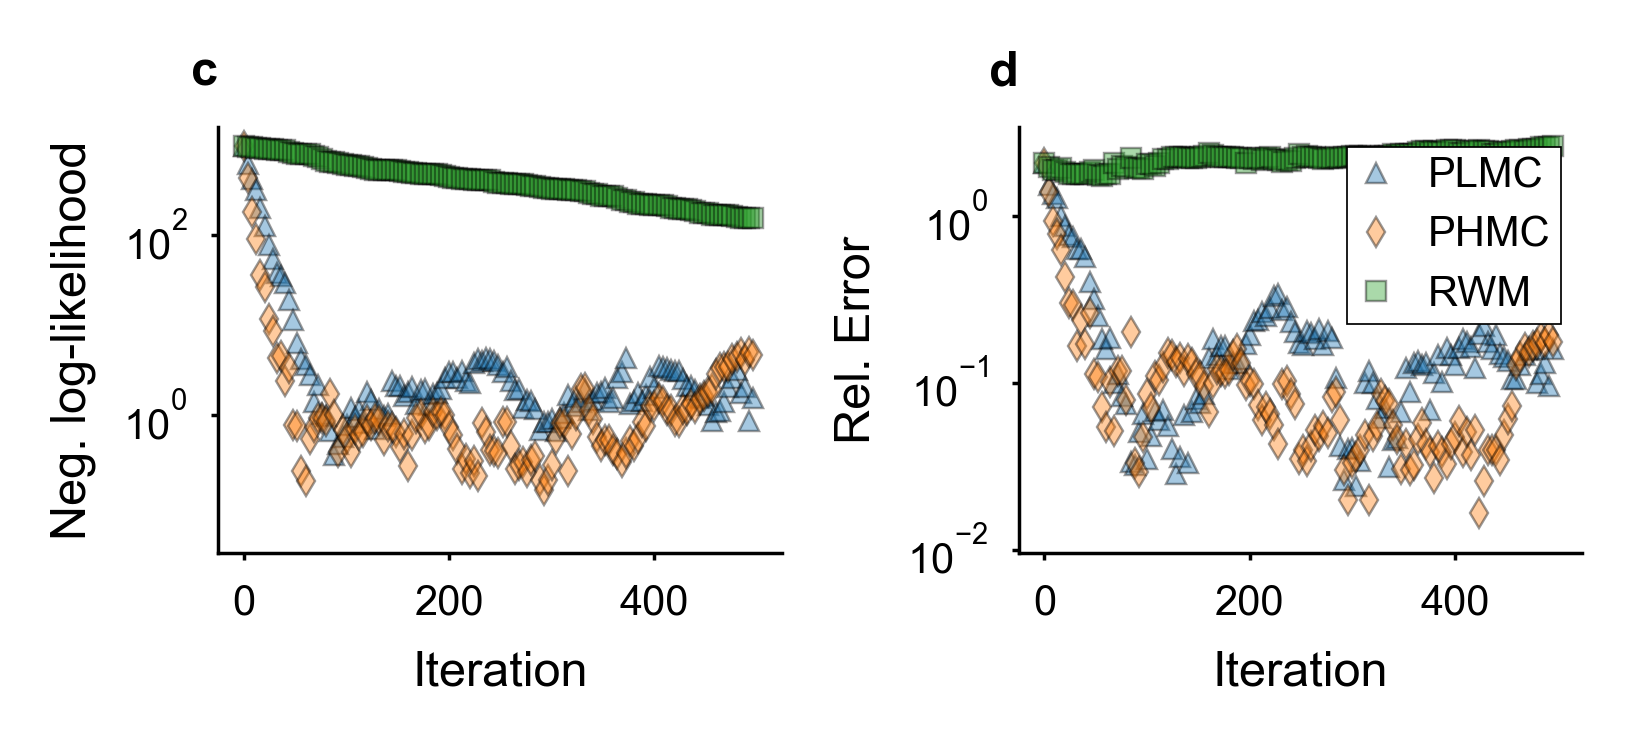

In [13]:
# Plot results
plt.style.use("./icmlstyle.mplstyle")

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Neg. log-likelihood")
ax1.semilogy((probs_lang), ls='None', marker="^", label="PLMC", alpha=0.4, markevery=4)
ax1.semilogy((probs_ham), ls='None', marker="d", label="PHMC", alpha=0.4, markevery=4)
ax1.semilogy((probs_rw), ls='None', marker="s", label="RWM", alpha=0.4, markevery=4)

ax2.set_xlabel("Iteration")
ax2.set_ylabel("Rel. Error")
ax2.semilogy(np.abs((samples_lang - thetatrue[np.newaxis, :])/thetatrue[np.newaxis, :]).mean(axis=1),  ls='None', marker="^", label="PLMC", alpha=0.4, markevery=4)
ax2.semilogy(np.abs((samples_ham - thetatrue[np.newaxis, :])/thetatrue[np.newaxis, :]).mean(axis=1), ls='None', marker="d", label="PHMC", alpha=0.4, markevery=4)
ax2.semilogy(np.abs((samples_rw - thetatrue[np.newaxis, :])/thetatrue[np.newaxis, :]).mean(axis=1), ls='None', marker="s", label="RWM", alpha=0.4, markevery=4)


ax2.legend()
ax1.set_title("c", loc="left", fontweight='bold', ha='right')
ax2.set_title("d", loc="left", fontweight='bold', ha='right')


ax1.minorticks_off()
ax2.minorticks_off()
plt.tight_layout()
plt.savefig("./figures/figure5_sampling_right")

plt.show()